# Reproducible Environment

* OS: maxOS Sonoma 14.2.1 (23C71)
* Chip: Apple M1 Max
* RAM: 64GB

In [1]:
# If you haven't installed the following packages, you need to install them first
# !pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from typing import List, Dict
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy import stats
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from miao import parse_miao_db_yml, auto_detect_tms, create_Tms, \
    prepare_var, miao_phase1_with_period_shifts, miao_phase2_with_period_shifts

import pandas as pd

warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=ValueWarning)

# Auto detecting $T_m$

The `miao.auto_detect_tms` function automatically detects the "start_date" and "end_date" for each OSS project's analysis. Based on settings of experiment, the maximum analysis period is 4 years, and if the period exceeds this, it will be divided into segments. However, if the last segment is less than 4 years, the analysis start date is set to 4 years before the end date.

For example, if the last period segment is from 2021-01-01 to 2023-01-01, since this is only a 2-year period, the analysis period will be adjusted to span from 2019-01-01 to 2023-01-01.

Note that since projects with analysis periods of less than 4 years are also included in the analysis targets, there exist groups whose analysis periods are not necessarily 4 years.

In [25]:
db = parse_miao_db_yml("./db.yml")

tms_map = {}

for row in db:
    tms = auto_detect_tms(row)
    tms_map[row["name"]] = tms
    
for repo in tms_map:
    print(f"- {repo}")
    for tm in tms_map[repo]:
        print(" -", tm)
    print("")

- chainer/chainer
 - {'start': Timestamp('2016-09-25 00:00:00'), 'end': Timestamp('2020-02-25 00:00:00')}

- Theano/Theano
 - {'start': Timestamp('2015-11-07 00:00:00'), 'end': Timestamp('2018-02-07 00:00:00')}

- docker-archive/classicswarm
 - {'start': Timestamp('2014-06-06 00:00:00'), 'end': Timestamp('2016-09-06 00:00:00')}

- bcit-ci/CodeIgniter
 - {'start': Timestamp('2013-01-10 00:00:00'), 'end': Timestamp('2017-01-10 00:00:00')}
 - {'start': Timestamp('2015-01-10 00:00:00'), 'end': Timestamp('2019-01-10 00:00:00')}

- zendframework/zendframework
 - {'start': Timestamp('2010-01-04 00:00:00'), 'end': Timestamp('2014-01-04 00:00:00')}
 - {'start': Timestamp('2011-01-04 00:00:00'), 'end': Timestamp('2015-01-04 00:00:00')}

- atom/atom
 - {'start': Timestamp('2015-11-13 00:00:00'), 'end': Timestamp('2019-11-13 00:00:00')}
 - {'start': Timestamp('2017-11-13 00:00:00'), 'end': Timestamp('2021-11-13 00:00:00')}

- fuel/fuel
 - {'start': Timestamp('2013-01-10 00:00:00'), 'end': Timestam

# Preparation for VAR Analysis


The `miao.prepare_var` function corresponds to PREPARE_VAR in the algorithm presented in the paper. prepare_var performs the following processes and returns input variables for VAR with optimal lag and preprocessed $A_i$:

* Extract subsequence $A_{T_m}$ from $A = [A_1, A_2, A_3]$ corresponding to $T_m$
* Apply seasonal adjustment with 7-day periodicity to $A_{T_m}$
* Conduct ADF test on $A_{T_m}$
* Apply fractional differencing if $A_{T_m}$ has unit root
* Search for lag between 1 and 15 that has Ljung-Box test $p \geq 0.1$ and minimum AIC (if none exists, select the * one with minimum AIC)

In [5]:
tms = tms_map["chainer/chainer"]
repos = [c["name"] for c in db[0]["competitors"]] + [db[0]["name"]]

T = create_Tms(tms[0]["start"], tms[0]["end"], 12, split_interval=False)

As = []

for repo in repos:
    A = pd.read_csv(f"./datasets/original/daily/{repo}.csv", index_col=0)
    As.append((repo, A))
    
X_each_tm = prepare_var(T, As)
assert(len(X_each_tm) == len(T))

Failed to reject the H0 of whiteness test: pvalue=0.26026209439413395, lag=4, adf_p=0.000, 0.000, 0.016
Failed to reject the H0 of whiteness test: pvalue=0.9037414058396334, lag=10, adf_p=0.000, 0.000, 0.001
Failed to reject the H0 of whiteness test: pvalue=0.34021716228650223, lag=8, adf_p=0.000, 0.000, 0.003
Failed to reject the H0 of whiteness test: pvalue=0.43114350093294684, lag=10, adf_p=0.000, 0.000, 0.011


`X_each_tm` stores input variables (represented as $\mathcal{D}'$ in the paper) to VAR from T1 up to a maximum of T4.

In [6]:
T1_lag, T1_X = X_each_tm[0]
T2_lag, T2_X = X_each_tm[1]
T3_lag, T3_X = X_each_tm[2]
T4_lag, T4_X = X_each_tm[3]

display(T1_X)
display(T2_X)
display(T3_X)
display(T4_X)

,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-09-25,44.628868,11.026147,12.399377
2016-09-26,51.154743,9.327045,12.032284
2016-09-27,47.139203,14.478136,11.579621
2016-09-28,45.563818,8.839176,10.030257
2016-09-29,43.418438,11.586757,13.192421
...,...,...,...
2017-09-20,39.521351,20.778812,19.713472
2017-09-21,35.893028,23.268836,17.478096
2017-09-22,38.221514,20.913732,15.996192


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-09-25,44.636608,11.047503,12.348567
2016-09-26,51.157936,9.300237,12.084038
2016-09-27,47.119255,14.599319,11.600481
2016-09-28,45.579762,8.815193,9.966478
2016-09-29,43.414560,11.716455,13.349029
...,...,...,...
2018-09-20,46.381797,17.640288,30.845210
2018-09-21,56.970568,14.965439,30.959513
2018-09-22,55.929304,20.087344,28.259031


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-09-25,49.168135,20.328901,22.644142
2016-09-26,50.977352,9.904016,13.222944
2016-09-27,52.283343,8.767610,5.232160
2016-09-28,29.803507,-0.751963,2.245335
2016-09-29,49.294349,5.668367,4.142771
...,...,...,...
2019-09-20,104.357536,33.349685,9.631782
2019-09-21,62.115778,31.733385,17.880866
2019-09-22,53.168135,17.328901,15.644142


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-09-25,44.518612,11.041205,12.757546
2016-09-26,51.180095,9.307330,11.385850
2016-09-27,47.798850,14.583310,9.812537
2016-09-28,44.312965,8.820920,10.601808
2016-09-29,43.455679,11.692829,12.837047
...,...,...,...
2020-02-20,99.364999,18.940577,-0.201003
2020-02-21,103.540332,20.129115,-0.595026
2020-02-22,101.401480,22.197809,0.140470


The DataFrame generated by prepare_var is identical to the data output under the datasets/preprocessed directory.

In [7]:
T1_X.sum().sum() == pd.read_csv(f"./datasets/preprocessed/original/T1/1_0.csv", index_col=0).sum().sum()

True

## Period shifts

In [8]:
shifts = [pd.DateOffset(months=1), pd.DateOffset(months=2), pd.DateOffset(months=3)]

for shift in shifts:
    print(f"-------------- {shift.months} month(s) shift --------------")
    
    shifted_start = tms[0]["start"] + shift
    shifted_end = tms[0]["end"] + shift

    shifted_T = create_Tms(shifted_start, shifted_end, 12, split_interval=False)

    As = []

    for repo in repos:
        A = pd.read_csv(f"./datasets/original/daily/{repo}.csv", index_col=0)
        As.append((repo, A))

    X_each_tm = prepare_var(shifted_T, As)
    assert(len(X_each_tm) == len(shifted_T))
    lag, X = X_each_tm[0]
    display(X)

-------------- 1 month(s) shift --------------
Failed to reject the H0 of whiteness test: pvalue=0.16258694751940767, lag=2, adf_p=0.000, 0.000, 0.000
Failed to reject the H0 of whiteness test: pvalue=0.380838500079139, lag=9, adf_p=0.000, 0.000, 0.040
Failed to reject the H0 of whiteness test: pvalue=0.35880917245070293, lag=8, adf_p=0.000, 0.000, 0.004
Failed to reject the H0 of whiteness test: pvalue=0.4348729169312024, lag=10, adf_p=0.000, 0.000, 0.016


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-10-25,55.279500,3.587672,21.754498
2016-10-26,52.355205,5.354796,12.306325
2016-10-27,48.786291,5.740706,13.695983
2016-10-28,48.077946,7.793749,11.256773
2016-10-29,52.537043,7.316242,7.306260
...,...,...,...
2017-10-20,34.617642,17.999191,10.797471
2017-10-21,40.249214,14.928915,13.198736
2017-10-22,37.043894,17.708182,13.271460


-------------- 2 month(s) shift --------------
Failed to reject the H0 of whiteness test: pvalue=0.9994047559161869, lag=10, adf_p=0.000, 0.000, 0.000
Failed to reject the H0 of whiteness test: pvalue=0.922576348485205, lag=10, adf_p=0.000, 0.000, 0.000
Failed to reject the H0 of whiteness test: pvalue=0.3384213035983776, lag=8, adf_p=0.000, 0.000, 0.004
Failed to reject the H0 of whiteness test: pvalue=0.372303296890559, lag=10, adf_p=0.000, 0.000, 0.019


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-11-25,-1.068381,0.226837,15.075807
2016-11-26,28.105288,19.204428,9.280289
2016-11-27,35.623496,12.383700,20.053398
2016-11-28,51.700688,11.519662,2.834642
2016-11-29,47.305084,28.939991,5.584642
...,...,...,...
2017-11-20,45.700688,14.519662,3.834642
2017-11-21,39.305084,6.939991,8.584642
2017-11-22,65.954028,6.408910,16.333510


-------------- 3 month(s) shift --------------
Failed to reject the H0 of whiteness test: pvalue=0.9987030291136866, lag=10, adf_p=0.000, 0.000, 0.000
Failed to reject the H0 of whiteness test: pvalue=0.9212020554932282, lag=10, adf_p=0.000, 0.000, 0.000
Failed to reject the H0 of whiteness test: pvalue=0.3551189025369247, lag=8, adf_p=0.000, 0.000, 0.008
Failed to reject the H0 of whiteness test: pvalue=0.8023275080304014, lag=14, adf_p=0.000, 0.000, 0.030


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-12-25,35.568366,16.381091,10.320559
2016-12-26,7.207021,6.918906,-7.836304
2016-12-27,13.716825,14.717225,24.340167
2016-12-28,9.324992,12.090798,6.015829
2016-12-29,13.264552,26.101787,-2.484171
...,...,...,...
2017-12-20,94.324992,17.090798,38.015829
2017-12-21,59.264552,8.101787,60.515829
2017-12-22,49.333072,12.697618,29.569859


# SVAR

The following is code that reads CSV data corresponding to shift, Tm, and group from datasets/preprocessed and estimates SVAR. For lags, it uses the pre-estimated values recorded in var_estimation_result.csv.

In [9]:
from statsmodels.tsa.vector_ar.svar_model import SVAR
import pandas as pd
import numpy as np

shift = "original"
Tm = "T1"
group_with_sep = "1_0"

var_result = pd.read_csv("./var_estimation_result.csv")
X = pd.read_csv(f"./datasets/preprocessed/{shift}/{Tm}/{group_with_sep}.csv", index_col=0)

# A matrix that represent recursive constraint. E will be estimated. 
A = np.array([
    [1, 0, 0],
    ["E", 1, 0],
    ["E", "E", 1]
])

cond = (var_result["group"] == group_with_sep) & (var_result["Tm"] == Tm) & (var_result["period_shift"] == shift)
lag = var_result[cond].iloc[0].lag 

model = SVAR(X, svar_type="A", A=A)
results = model.fit(maxlags=lag)

# IRF Calculation

The impulse response can be calculated using `irf = results.irf(period)`, and in the case of SVAR, the calculation results are stored in `irf.svar_irfs`. When the `irf.plot()` function is called, an n✕n figure is displayed. The shape of svar_irfs is a third-order tensor of dimensions (period, n, n).

In [10]:
# In our paper, period=200.
period = 20
irf = results.irf(period)

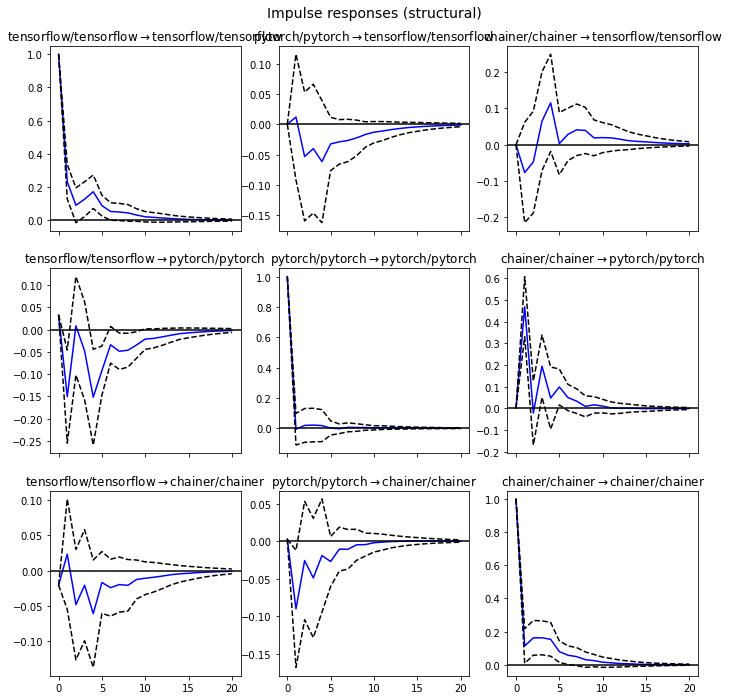

In [11]:
irf.plot();

## IRF Cum Effects

The cumulative impulse response can be obtained from `irf.svar_cum_effects`. The shape of it is same as svar_irfs. 

Similar to the regular IRF, you can plot the graph using `irf.plot_cum_effects()`. However, it is important to note that this graph shows the cumulative impulse responses based on the standard reduced-form VAR, not the SVAR-based impulse responses. Nevertheless, we will create this plot as an example to examine the shape of the cumulative impulse responses.

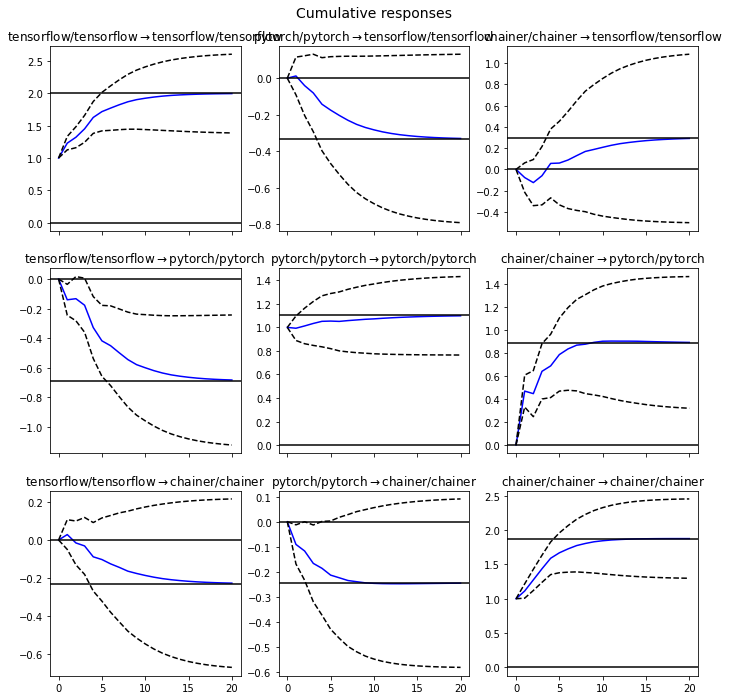

In [12]:
irf.plot_cum_effects();

In [13]:
irf.svar_cum_effects.shape

(21, 3, 3)

In [14]:
# svar_cum_effects of tensorflow -> tensorflow
irf.svar_cum_effects[:, 0, 0]

array([1.        , 1.23209312, 1.32281255, 1.44993998, 1.62188274,
       1.71054006, 1.76355166, 1.81356709, 1.85822927, 1.88993827,
       1.91113235, 1.92857537, 1.94240705, 1.95292282, 1.96040789,
       1.96618366, 1.97062425, 1.97398535, 1.97644727, 1.97829372,
       1.97968933])

In [15]:
# svar_cum_effects of pytorch -> chainer
irf.svar_cum_effects[:, 2, 1]

array([ 0.00289876, -0.08736001, -0.1131372 , -0.16210624, -0.18121534,
       -0.20823605, -0.21873769, -0.22945429, -0.23413174, -0.23860468,
       -0.24059005, -0.24170208, -0.24208157, -0.24215071, -0.24196193,
       -0.24158886, -0.24119289, -0.24077932, -0.24039274, -0.24002706,
       -0.23970764])

The last index of irf.svar_cum_effects corresponds to the SCE (Shock Cumulative Effect) between each pair of OSS.

In [16]:
irf.svar_cum_effects[-1]

array([[ 1.97968933, -0.32951079,  0.29104438],
       [-0.66598035,  1.10125865,  0.89208772],
       [-0.27482641, -0.23970764,  1.8767399 ]])

# MIAO Score Calculation

MIAO Score definition. 

$$
\mathrm{MS}_{ij} = (-1) \cdot \sum_{k=1}^m \mathrm{SCE}_{ij}^k
$$

In [17]:
shifts = ["original", "1_month_shifted", "2_month_shifted", "3_month_shifted"]
Tms = ["T1", "T2", "T3", "T4"]
group_with_sep = "1_0"

sces_with_shifts = miao_phase1_with_period_shifts(A, shifts, Tms, group_with_sep)

## MIAO Score Table

This result matches the corresponding csv results under the `miao_score_tables` directory

In [18]:
miao_score_table = miao_phase2_with_period_shifts(sces_with_shifts)
display(miao_score_table)

,AMS_ij
pytorch/pytorch -> tensorflow/tensorflow,-3.076139
chainer/chainer -> tensorflow/tensorflow,-3.578543
tensorflow/tensorflow -> pytorch/pytorch,-0.117943
chainer/chainer -> pytorch/pytorch,-0.983100
tensorflow/tensorflow -> chainer/chainer,-0.815324
pytorch/pytorch -> chainer/chainer,2.118299


In [19]:
# For Example, miao_score_tables/1_0.csv matches above table.
pd.read_csv("./miao_score_tables/1_0.csv", index_col=0)

,miao_score
pytorch/pytorch -> tensorflow/tensorflow,-3.076139
chainer/chainer -> tensorflow/tensorflow,-3.578543
tensorflow/tensorflow -> pytorch/pytorch,-0.117943
chainer/chainer -> pytorch/pytorch,-0.983100
tensorflow/tensorflow -> chainer/chainer,-0.815324
pytorch/pytorch -> chainer/chainer,2.118299


# Decision Tree

Training and Performance Evaluation of Decision Tree Model Using decision_tree_dataset.csv

Sample size: 64
Mean accuracy: 0.8125
Standard deviation of accuracy: 0.3903
95% confidence interval: (0.7142, 0.9108)

Classification Report:
              precision    recall  f1-score   support

      nonREV       0.83      0.78      0.81        32
         REV       0.79      0.84      0.82        32

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0.81      0.81      0.81        64


Confusion Matrix:


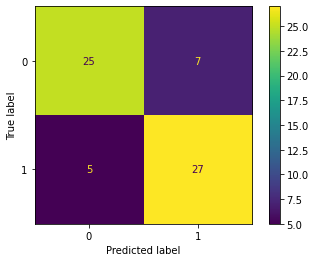

In [20]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy import stats
import matplotlib.pyplot as plt



params = {
    'max_depth': 3, 
    'min_samples_split': 10, 
    'min_samples_leaf': 3,
    'random_state': 42
}

data = pd.read_csv("./decision_tree_dataset.csv")
X = data.drop(['label', 'group', 'target'], axis=1)
y = data['label']

cv_scores = []
y_preds = []

loo = LeaveOneOut()

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = DecisionTreeClassifier(**params)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    cv_scores.append(accuracy_score(y_test, y_pred))
    y_preds.append(y_pred[0])

cv_scores = np.array(cv_scores)
confidence_level = 0.95
degrees_of_freedom = len(cv_scores) - 1
sample_mean = np.mean(cv_scores)
sample_standard_error = stats.sem(cv_scores)

ci_low, ci_high = stats.t.interval(confidence_level, degrees_of_freedom, 
                                   loc=sample_mean, 
                                   scale=sample_standard_error)

print(f"Sample size: {len(y)}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation of accuracy: {cv_scores.std():.4f}")
print(f"95% confidence interval: ({ci_low:.4f}, {ci_high:.4f})")

print("")
print("Classification Report:")
print(classification_report(y, y_preds, target_names=["nonREV", "REV"]))


print("")
print("Confusion Matrix:")


cm = confusion_matrix(y, y_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot();